# Creating a dataset of only single object images

In [9]:
import os
import json
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from diffusers import AutoencoderKL
from tqdm.notebook import tqdm
from datasets import load_dataset
from PIL import Image, ImageDraw
from os.path import join


class SingleShapeDataset(Dataset):
    def __init__(self, num_images, resolution=64, radius=8, transform=None):
        self.num_images = num_images
        self.shapes = ['triangle', 'circle', 'square']
        self.colors = ['red', 'blue']
        self.canvas_size = resolution
        self.radius = radius
        self.transform = transform 
        self.shape_to_idx = {'triangle': 0, 'circle': 1, 'square': 2}
        self.color_to_rgb = {'red': 'red', 'blue': 'blue'}

    def __len__(self):
        return self.num_images
    
    def draw_shape_on_image(self, img, shape, location, color):
        draw = ImageDraw.Draw(img)
        x, y = location
        
        if shape == 'circle':
            r = self.radius
            draw.ellipse([(x - r, y - r), (x + r, y + r)], fill=color)
        elif shape == 'square':
            s = self.radius * 2
            draw.rectangle([(x - s//2, y - s//2), (x + s//2, y + s//2)], fill=color)
        elif shape == 'triangle':
            s = self.radius * 2
            h = s * (3 ** 0.5) / 2
            point1 = (x, y - h / 3)
            point2 = (x - s / 2, y + h * 2 / 3)
            point3 = (x + s / 2, y + h * 2 / 3)
            draw.polygon([point1, point2, point3], fill=color)

        return img
    

    def __getitem__(self, idx):
        # Blank image
        img = Image.new('RGB', (self.canvas_size, self.canvas_size), 'gray')

        # Randomly select shape and color
        shape = random.choice(self.shapes)
        color = random.choice(self.colors)

        # Random location
        x = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)

        # Draw the shape
        img = self.draw_shape_on_image(img, shape, (x, y), color=self.color_to_rgb[color])

        # Convert image
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Create caption
        caption = f"a {color} {shape}"

        labels = {
            'shape': self.shape_to_idx[shape],
            'location': torch.tensor([x, y], dtype=torch.float32),
            'caption': caption
        }

        return img, labels


Images batch shape: torch.Size([16, 3, 64, 64])
Labels batch: {'shape': tensor([0, 0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 2, 2]), 'location': tensor([[25., 13.],
        [22., 35.],
        [45., 50.],
        [48., 18.],
        [46., 34.],
        [47., 43.],
        [31., 24.],
        [46.,  9.],
        [54., 41.],
        [28.,  9.],
        [36., 12.],
        [25., 26.],
        [36., 22.],
        [36., 43.],
        [27., 19.],
        [13., 20.]]), 'caption': ['triangle', 'triangle', 'square', 'square', 'circle', 'triangle', 'circle', 'triangle', 'triangle', 'square', 'square', 'circle', 'triangle', 'triangle', 'square', 'square']}
Sample of batch captions:
Image 0: triangle
Image 1: triangle
Image 2: square


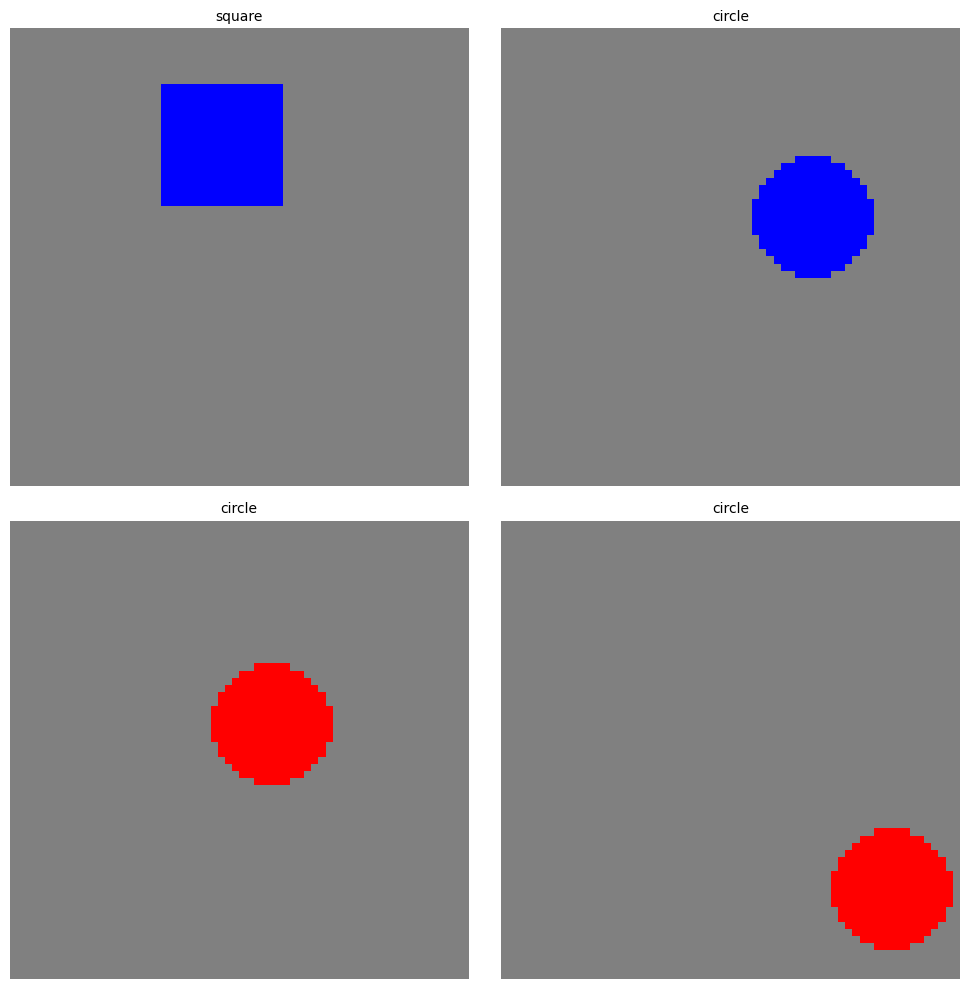

In [2]:
if __name__ == '__main__':

    # Define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Create dataset and dataloader
    dataset = SingleShapeDataset(num_images=1000, transform=transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Inspect one batch
    for images, labels in dataloader:
        print(f"Images batch shape: {images.size()}")
        print(f"Labels batch: {labels}")
        print("Sample of batch captions:")
        for i in range(min(3, len(images))):
            print(f"Image {i}: {labels['caption'][i]}")
        break

    # Display a few images and captions
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(4):
        img, lbl = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_np)
        axes[i].set_title(lbl['caption'], fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the single-object dataset
dataset = SingleShapeDataset(num_images=10000, transform=transform, radius=16, resolution=128)

# Sample 10,000 images and store images + labels
images = []
labels = []

for i in range(10000):
    img, lbl = dataset[i]
    images.append(img)
    labels.append(lbl)

# Stack all images into a single tensor
image_tensors = torch.stack(images)  # shape: [10000, 3, H, W]

# Inspect image statistics
print("Mean pixel value:", image_tensors.mean().item())
print("Std dev of pixel values:", image_tensors.std().item())


Mean pixel value: 0.4936067759990692
Std dev of pixel values: 0.11112222075462341


In [4]:

# Extract single-object labels
shapes = torch.tensor([item['shape'] for item in labels], dtype=torch.long)
locations = torch.stack([item['location'] for item in labels], dim=0)

# Create a TensorDataset (no need for shape2/location2)
dataset = TensorDataset(image_tensors, shapes, locations)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inspect a batch
batch = next(iter(dataloader))
images_batch, shapes_batch, locations_batch = batch

print("Image batch shape:", images_batch.shape)
print("Shape indices:", shapes_batch)
print("Locations:", locations_batch)


Image batch shape: torch.Size([16, 3, 128, 128])
Shape indices: tensor([1, 2, 1, 1, 2, 0, 0, 2, 2, 1, 2, 1, 0, 0, 2, 0])
Locations: tensor([[ 71.,  82.],
        [110., 101.],
        [ 44.,  64.],
        [ 63.,  44.],
        [ 31.,  81.],
        [ 27.,  85.],
        [ 43.,  17.],
        [ 96.,  29.],
        [ 59.,  61.],
        [107.,  62.],
        [ 46.,  30.],
        [ 45.,  85.],
        [106.,  31.],
        [ 34.,  49.],
        [ 59., 101.],
        [ 68.,  60.]])


In [ ]:
### Cache and save the dataset to disk


# Define save path
save_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation"
os.makedirs(save_dir, exist_ok=True)
# save_path = os.path.join(save_dir, "shapes_single_dataset.pth")
save_path = os.path.join(save_dir, "shapes_single_dataset.pth")


# Save as a dictionary
torch.save({
    "images": image_tensors,     # shape: [N, 3, H, W]
    "shapes": shapes,            # shape: [N]
    "locations": locations       # shape: [N, 2]
}, save_path)

print(f"Saved single-object dataset to: {save_path}")


Saved single-object dataset to: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation/shapes_single_dataset_2.pth


In [6]:

class SingleShapesDatasetCached(Dataset):
    def __init__(self, path, transform=None):
        """
        Loads cached single-object dataset from .pth file.

        Args:
        - path: path to the .pth file
        - transform: optional transform to apply to each image
        """
        self.data = torch.load(path)
        self.images = self.data["images"]
        self.shapes = self.data["shapes"]
        self.locations = self.data["locations"]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        shape = self.shapes[idx]
        location = self.locations[idx]

        if self.transform:
            img = self.transform(img)

        return img, (shape, location)


In [ ]:
# Reload cached dataset
transform = transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
dataset = SingleShapesDatasetCached(path="/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation/shapes_single_dataset.pth", transform=transform)

# Create a dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inspect a batch
batch = next(iter(dataloader))
images, (shapes, locations) = batch
print(images.shape, shapes.shape, locations.shape)


/tmp/ipykernel_439012/3173275002.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(path)


torch.Size([16, 3, 128, 128]) torch.Size([16]) torch.Size([16, 2])


# Load the cached dataset and encode images using VAE

In [ ]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = SingleShapesDatasetCached(
    path="/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation/shapes_single_dataset.pth",
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


/tmp/ipykernel_439012/3173275002.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(path)


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
vae = AutoencoderKL.from_pretrained(vae_model).to(device)


In [10]:
dataset[0][0].shape

torch.Size([3, 128, 128])

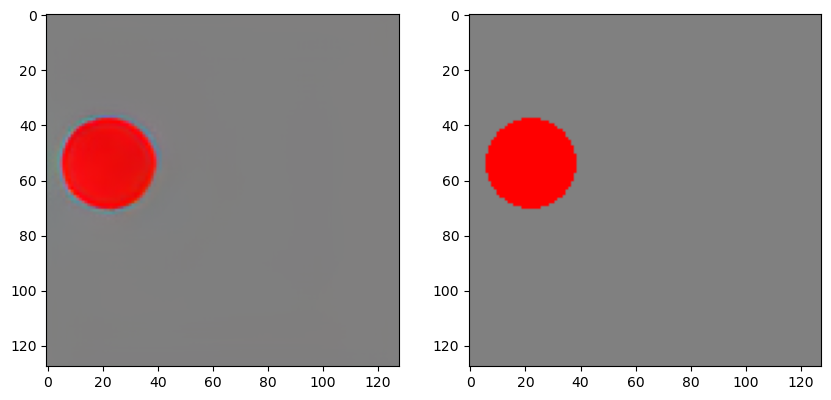

In [11]:
image_tsr = dataset[0][0].unsqueeze(0)
with torch.no_grad():
    latent_dist = vae.encode(image_tsr.to(device)).latent_dist # * 2 - 1
    latent_sample = latent_dist.sample()
    image_rec = (vae.decode(latent_sample).sample * 0.5 + 0.5).clamp(0,1)
    # latent_mean = latent_dist.mean
    # image_rec = vae.decode(latent_mean).sample * 0.5 + 0.5
image_rec.shape

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rec[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow((image_tsr[0] * 0.5 + 0.5).clamp(0,1).permute(1, 2, 0).cpu().numpy())

# Make it into a pixart trainable dataset

In [12]:
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize, CenterCrop

In [13]:
tfm =Compose([Normalize(0.5,0.5)])

In [14]:
tfm(ToTensor()(ToPILImage()(torch.randn(3, 128, 128))))

tensor([[[ 0.2471,  0.9451, -0.0588,  ...,  0.7020,  0.7020,  0.7333],
         [-0.2549, -0.6471,  0.4745,  ..., -0.4588,  0.6000, -0.5765],
         [-0.8353, -0.4353,  0.3882,  ..., -0.1843, -0.7412, -0.3725],
         ...,
         [-0.3725,  0.8745, -0.3569,  ...,  0.1294,  0.4353,  0.8588],
         [-0.4667, -0.7490, -0.3725,  ...,  0.8824,  0.5608,  0.9608],
         [-0.2471,  0.3569,  0.1765,  ..., -0.5216,  0.8118, -0.6706]],

        [[-0.3255,  0.0824,  0.1608,  ..., -0.0196, -0.0039, -0.7961],
         [ 0.8588, -0.7020, -0.9765,  ..., -0.1373, -0.3725, -0.6941],
         [ 0.2000,  0.8510,  0.7882,  ...,  0.5294, -0.5137,  0.6314],
         ...,
         [-0.3725, -0.9059, -0.0902,  ..., -0.0353,  0.4588, -0.9294],
         [ 0.3020,  0.3961, -0.2471,  ..., -0.2078, -0.9294,  0.2000],
         [-0.6157,  0.5765,  0.6471,  ..., -0.4667, -0.8588, -0.4118]],

        [[-0.9294,  0.0745, -0.5608,  ..., -0.7255,  0.9451, -0.5608],
         [ 0.3255,  0.3647,  0.1922,  ..., -0

In [15]:
transform

Compose(
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

Note that with vision, the formats matter! PIL image != tensors. These are two very different formats. 

In [16]:
transform = transforms.Compose([
    lambda x: x.convert("RGB"),
    # Add more transforms if needed
])
resolution = 128
dataset = SingleShapeDataset(num_images=10000, resolution=resolution, radius=16, transform=transform)

root_dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot2"
images_dir = "images"
captions_dir = "captions"

images_dir_absolute = join(root_dir, images_dir)
captions_dir_absolute = join(root_dir, captions_dir)

if not os.path.exists(root_dir):
    os.makedirs(join(root_dir, images_dir))

if not os.path.exists(join(root_dir, images_dir)):
    os.makedirs(join(root_dir, images_dir))
if not os.path.exists(join(root_dir, captions_dir)):
    os.makedirs(join(root_dir, captions_dir))

image_format = "png"
json_name = "partition/data_info.json"
if not os.path.exists(join(root_dir, "partition")):
    os.makedirs(join(root_dir, "partition"))

absolute_json_name = join(root_dir, json_name)
data_info = []

for order, (image, labels) in tqdm(enumerate(dataset)): 
    if order >= 10000:
        break
    image = image
    image.save(f"{images_dir_absolute}/{order}.{image_format}")
    with open(f"{captions_dir_absolute}/{order}.txt", "w") as text_file:
        text_file.write(labels["caption"])
    
    width, height = resolution, resolution
    ratio = 1
    data_info.append({
        "height": height,
        "width": width,
        "ratio": ratio,
        "path": f"{order}.{image_format}", # images/ # if there is images/ in the path it will cause error in InternalData.py L55, L56. 
        "prompt": labels["caption"],
    })        

with open(absolute_json_name, "w") as json_file:
    json.dump(data_info, json_file)

0it [00:00, ?it/s]

In [17]:
with open(absolute_json_name, "w") as json_file:
    json.dump(data_info, json_file)

absolute_json_name

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot3/partition/data_info.json'

# Extract Features 

In [18]:
%cd ../PixArt-alpha
!python ~/Github/DiffusionObjectRelation/PixArt-alpha/tools/extract_features.py \
    --img_size 128 \
    --max_tokens 20 \
    --dataset_root "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot2" \
    --json_path "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot2/partition/data_info.json" \
    --t5_save_root "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot2/caption_feature_wmask" \
    --vae_save_root "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot2/img_vae_features" \
    --pretrained_models_dir "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models"

/n/home12/hjkim/Github/DiffusionObjectRelation/PixArt-alpha
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/hjkim/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. 

In [19]:
!du -sh /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot2/*

1.1G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot3/caption_feature_wmask
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot3/captions
40M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot3/images
118M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot3/img_vae_features_128resolution
824K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRelSingle_pilot3/partition


In [20]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models

PixArt-XL-2-1024-MS.pth  PixArt-XL-2-512x512.pth  sd-vae-ft-ema  t5_ckpts
